# Import requirements

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 8.3 MB/s 
     |████████████████████████████████| 7.6 MB 83.9 MB/s 
     |████████████████████████████████| 182 kB 92.4 MB/s 


In [5]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

#new model
from transformers import (

    AutoModelForSequenceClassification,
    AutoTokenizer,

)

# 1. Preprocess

In [6]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [7]:
tokenizer = AutoTokenizer.from_pretrained('VictorSanh/roberta-base-finetuned-yelp-polarity')

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/559 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [8]:
from google.colab import files
uploaded = files.upload()

Saving sentiment.dev.0 to sentiment.dev.0
Saving sentiment.dev.1 to sentiment.dev.1
Saving sentiment.train.0 to sentiment.train.0
Saving sentiment.train.1 to sentiment.train.1
Saving test_no_label.csv to test_no_label.csv


In [9]:
!ls

sample_data	 sentiment.dev.1    sentiment.train.1
sentiment.dev.0  sentiment.train.0  test_no_label.csv


In [10]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


In [11]:
train_pos[:10]

['0 3463 39462 689 479 50118 2',
 '0 16101 428 2111 544 479 50118 2',
 '0 10010 67 33 1230 24827 8 2480 6353 61 16 269 205 479 50118 2',
 '0 405 128 29 10 205 7 14317 9379 1073 324 479 50118 2',
 '0 627 813 16 5192 479 50118 2',
 '0 8396 2003 689 479 50118 2',
 '0 8396 544 479 50118 2',
 '0 29 18615 9 183 16 17798 8 3739 9 24827 479 50118 2',
 '0 12338 317 13 4592 50 2003 14967 8 4437 479 50118 2',
 '0 627 92 1186 1326 2770 479 50118 2']

In [12]:
train_neg[:10]

['0 118 21 16748 22037 479 50118 2',
 '0 2527 15 7 5 9379 1073 918 2156 5 24 21999 16 937 422 9 5 7259 479 50118 2',
 '0 4691 16980 4884 8 10 4866 9 30274 24515 479 50118 2',
 '0 23702 269 780 359 45 11314 9 5 68 18134 42666 1215 425 6694 479 50118 2',
 '0 10815 2156 5 19464 9379 1073 324 2156 24 16 35790 22191 479 50118 2',
 '0 118 56 7 582 68 18134 42666 1215 7 1606 7134 7 5 9379 1073 324 479 50118 2',
 '0 8877 174 162 89 21 10 1427 13 5 10386 15 5 526 479 50118 2',
 '0 1322 47 27537 162 17487 50118 2',
 '0 118 21 45 164 7 582 13 5 10386 15 5 526 479 50118 2',
 '0 118 2740 24 396 24515 2156 20406 2156 21568 2156 50 10386 479 50118 2']

In [13]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [14]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [15]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([    0,  3463, 39462,   689,   479, 50118,     2]), array([1]))
(array([    0, 16101,   428,  2111,   544,   479, 50118,     2]), array([1]))
(array([    0, 10010,    67,    33,  1230, 24827,     8,  2480,  6353,
          61,    16,   269,   205,   479, 50118,     2]), array([1]))
(array([    0,   405,   128,    29,    10,   205,     7, 14317,  9379,
        1073,   324,   479, 50118,     2]), array([1]))
(array([    0,   627,   813,    16,  5192,   479, 50118,     2]), array([1]))
(array([    0,  8396,  2003,   689,   479, 50118,     2]), array([1]))
(array([    0,  8396,   544,   479, 50118,     2]), array([1]))
(array([    0,    29, 18615,     9,   183,    16, 17798,     8,  3739,
           9, 24827,   479, 50118,     2]), array([1]))
(array([    0, 12338,   317,    13,  4592,    50,  2003, 14967,     8,
        4437,   479, 50118,     2]), array([1]))
(array([    0,   627,    92,  1186,  1326,  2770,   479, 50118,     2]), array([1]))
(array([    0,  9226,   317,    21,   

In [16]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)

    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)

    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [17]:
train_batch_size=128 #batch size -> 32 to 256
eval_batch_size=128 #batch size -> 64 to 512

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=True, collate_fn=collate_fn_style, 
                                         num_workers=2)

In [18]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('VictorSanh/roberta-base-finetuned-yelp-polarity')
model.to(device)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at VictorSanh/roberta-base-finetuned-yelp-polarity were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [19]:
model.train()
learning_rate = 2.5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps = 1e-6, weight_decay = 1e-2)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [21]:
import matplotlib.pyplot as plt
import time
iter_x = []
max_iteration = 0
acc_y = []
loss_y = []

starttime = time.time()

In [22]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer, lr_lambda = lambda epoch : 0.9** epoch, last_epoch=-1,verbose=False)
train_epoch = 3
lowest_valid_loss = 9999.
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            # output = model(input_ids=input_ids,
            #                attention_mask=attention_mask,
            #                token_type_ids=token_type_ids,
            #                position_ids=position_ids,
            #                labels=labels)
            output = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        position_ids=position_ids,
                        labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

            #### matplotlib ###
            if max_iteration < iteration:
                max_iteration = iteration
                if epoch>0:
                    assert False
            ### matplotlib ###

            if iteration != 0 and iteration % int(len(train_loader) / 10) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        # output = model(input_ids=input_ids,
                        #                attention_mask=attention_mask,
                        #                token_type_ids=token_type_ids,
                        #                position_ids=position_ids,
                        #                labels=labels)
                        output = model(input_ids=input_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids,
                                        position_ids=position_ids,
                                        labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)

                ### matplotlib start ###
                
                iter_x.append(iteration)
                acc_y.append(acc)
                loss_y.append(valid_loss)
                
                ### matplotlib end ###
    
                if lowest_valid_loss > valid_loss:
                    print('Acc for model which have lower valid loss: ', acc)
                    torch.save(model.state_dict(), "./pytorch_model.bin")
                    lowest_valid_loss = valid_loss
        scheduler.step()

Eval:  97%|█████████▋| 31/32 [00:01<00:00, 21.84it/s]
                                                     

Acc for model which have lower valid loss:  0.959


Eval:  97%|█████████▋| 31/32 [00:01<00:00, 21.47it/s]
                                                     

Acc for model which have lower valid loss:  0.96925


Eval:  94%|█████████▍| 30/32 [00:01<00:00, 21.38it/s]
                                                     

Acc for model which have lower valid loss:  0.97375


Eval:  97%|█████████▋| 31/32 [00:01<00:00, 21.50it/s]
                                                     

Acc for model which have lower valid loss:  0.97225


Eval:  97%|█████████▋| 31/32 [00:01<00:00, 21.80it/s]
                                                     

Acc for model which have lower valid loss:  0.97475


Eval:  94%|█████████▍| 30/32 [00:01<00:00, 21.74it/s]
                                                     

Acc for model which have lower valid loss:  0.97775


Eval:  97%|█████████▋| 31/32 [00:01<00:00, 21.75it/s]
                                                     

Acc for model which have lower valid loss:  0.97775


Eval:  97%|█████████▋| 31/32 [00:01<00:00, 21.59it/s]
                                                     

Acc for model which have lower valid loss:  0.98125


Epoch 2: 100%|██████████| 3463/3463 [07:20<00:00,  7.87batch/s, loss=0.0523]


In [23]:
endtime = time.time()

In [24]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [25]:
test_dataset = test_df['Id']

In [26]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [27]:
test = make_id_file_test(tokenizer, test_dataset)

In [28]:
test[:10]

['0 405 128 29 10 1086 92 676 8 92 14250 349 86 47 213 479 2',
 '0 2527 6770 31 41 793 2674 479 2',
 '0 405 16 5 144 12757 3553 1439 11 5 15044 479 2',
 '0 5016 45 1203 10 7792 19 209 82 479 2',
 '0 118 21 7464 8 79 156 162 619 98 3473 8 2814 479 2',
 '0 627 129 631 52 829 14 21 2131 21 5 3895 479 2',
 '0 2362 2156 45 5 1980 23 25 257 2156 5 1980 11 3812 239 479 2',
 '0 10010 836 24 66 760 13 47 8 32 182 7163 479 2',
 '0 7269 5 22633 222 295 75 190 216 141 7 173 5 3034 479 2',
 '0 10010 33 41 4206 4230 9 44505 7 2807 31 479 2']

In [29]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [30]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [31]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)

    #sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1] #bug
    sorted_indices = [i for i in range(len(input_ids))]
    
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [32]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

In [33]:
with torch.no_grad():
    model.eval()
    predictions = []
    ex0 = []
    ex1 = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        # output = model(input_ids=input_ids,
        #                attention_mask=attention_mask,
        #                token_type_ids=token_type_ids,
        #                position_ids=position_ids)
        output = model(input_ids=input_ids,
                      attention_mask=attention_mask,
                      token_type_ids=token_type_ids,
                      position_ids=position_ids)

        logits = output.logits
        print(logits)
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        ex0 += [example[0].cpu().numpy() for example in logits]
        ex1 += [example[1].cpu().numpy() for example in logits]
        predictions += batch_predictions


Test:  19%|█▉        | 6/32 [00:00<00:00, 27.54it/s]

tensor([[-4.8010,  4.5109],
        [ 3.4692, -3.4036],
        [-4.7970,  4.5236],
        [ 4.1269, -3.9702],
        [-4.7866,  4.5148],
        [ 3.4424, -3.3132],
        [ 3.8316, -3.6704],
        [-3.0936,  2.8113],
        [ 3.6800, -3.5503],
        [-4.7529,  4.5045],
        [-4.7303,  4.4564],
        [ 3.9789, -3.8295],
        [ 2.9200, -2.7271],
        [-4.3831,  4.1234],
        [-4.7821,  4.5037],
        [ 3.9395, -3.8129],
        [ 1.7138, -1.5932],
        [-3.3410,  3.0445],
        [ 4.1542, -3.9884],
        [ 4.0814, -3.9699],
        [ 4.2966, -4.1256],
        [-4.0964,  3.8390],
        [ 3.6440, -3.4798],
        [-4.7467,  4.5240],
        [ 3.5992, -3.4393],
        [ 2.7796, -2.6426],
        [-3.2137,  2.9315],
        [-3.9790,  3.7113],
        [ 3.1650, -3.0306],
        [ 4.2990, -4.1434],
        [ 3.6168, -3.4737],
        [ 3.0627, -2.9602]], device='cuda:0')
tensor([[ 3.2546, -3.1239],
        [ 3.9433, -3.8192],
        [ 3.0515, -2.9090],
  


Test:  50%|█████     | 16/32 [00:00<00:00, 40.77it/s]

tensor([[ 4.0187, -3.8705],
        [-4.7746,  4.5071],
        [-4.7957,  4.5199],
        [ 2.3852, -2.3182],
        [ 3.8260, -3.6738],
        [ 2.1937, -2.0413],
        [ 3.2207, -3.0923],
        [-4.7918,  4.5283],
        [-4.7906,  4.5363],
        [-4.5309,  4.2709],
        [ 4.1824, -4.0372],
        [-3.2194,  2.9456],
        [-4.1918,  3.9465],
        [-4.7992,  4.5172],
        [-4.8161,  4.5134],
        [-4.7767,  4.5078],
        [-4.7806,  4.5288],
        [-3.8486,  3.6055],
        [-4.8030,  4.5313],
        [-4.4884,  4.2202],
        [-4.2632,  4.0152],
        [-4.3174,  4.0349],
        [-4.7889,  4.5248],
        [-4.0710,  3.8236],
        [-4.7790,  4.5174],
        [ 4.1897, -4.0553],
        [-3.2378,  2.9711],
        [ 2.5202, -2.4361],
        [ 1.3187, -1.2003],
        [ 3.6258, -3.5024],
        [ 4.1968, -4.0623],
        [-0.5927,  0.5628]], device='cuda:0')
tensor([[ 3.9495, -3.8311],
        [-3.4336,  3.1648],
        [-4.6631,  4.3972],
  


Test:  81%|████████▏ | 26/32 [00:00<00:00, 45.43it/s]

tensor([[ 3.0948, -2.9899],
        [-3.7498,  3.4741],
        [ 3.1309, -2.9892],
        [ 3.6404, -3.4880],
        [ 2.7323, -2.6018],
        [ 3.1191, -3.0236],
        [-4.7489,  4.4689],
        [ 3.5666, -3.4583],
        [-3.3231,  3.0719],
        [ 3.0764, -2.9838],
        [-4.7360,  4.4390],
        [ 2.5515, -2.4641],
        [ 3.2385, -3.1605],
        [-4.7856,  4.5240],
        [ 4.1942, -4.0586],
        [ 1.5460, -1.4269],
        [-4.7501,  4.4941],
        [-4.7578,  4.4807],
        [-3.0293,  2.7813],
        [ 3.4609, -3.3392],
        [-4.2561,  3.9913],
        [ 3.2845, -3.1518],
        [ 3.7126, -3.5704],
        [ 4.0468, -3.9010],
        [-4.8023,  4.5333],
        [ 3.5989, -3.4532],
        [ 4.0724, -3.9270],
        [ 4.4802, -4.3389],
        [ 4.4470, -4.3198],
        [-4.1380,  3.8859],
        [ 3.1821, -3.0739],
        [ 3.6031, -3.4504]], device='cuda:0')
tensor([[ 4.0624, -3.9423],
        [ 4.0018, -3.8647],
        [ 4.3157, -4.1686],
  


Test:  97%|█████████▋| 31/32 [00:00<00:00, 46.07it/s]
                                                     

tensor([[-4.6596,  4.3915],
        [-3.4427,  3.1644],
        [ 2.0920, -1.9351],
        [-3.3002,  3.0095],
        [-4.6976,  4.4201],
        [-1.9805,  1.8630],
        [-4.3478,  4.0648],
        [ 4.0795, -3.9192],
        [ 3.3390, -3.1978],
        [ 4.1383, -3.9538],
        [ 3.3351, -3.1751],
        [-4.1352,  3.8805],
        [ 3.4891, -3.3400],
        [-4.8070,  4.5209],
        [-4.7938,  4.5299],
        [ 2.9895, -2.8769],
        [ 3.8966, -3.7525],
        [ 2.4213, -2.3099],
        [-4.7801,  4.5389],
        [ 3.7172, -3.5893],
        [-0.0710,  0.0933],
        [-4.3414,  4.0752],
        [-3.3688,  3.0976],
        [-4.8023,  4.5299],
        [ 3.7373, -3.6002],
        [ 3.9512, -3.8011],
        [-4.7799,  4.4991],
        [ 2.8142, -2.6815],
        [ 3.8332, -3.6930],
        [ 4.3044, -4.1550],
        [-4.2840,  4.0564],
        [-4.7897,  4.5245]], device='cuda:0')
tensor([[ 4.4233, -4.2805],
        [ 3.9039, -3.7837],
        [-4.6266,  4.3572],
  

In [34]:
test_df['Category'] = predictions

In [35]:
test_df.to_csv('roberta-base-finetuned-yelp.csv', index=False)

In [36]:
test_df['ex0'] = ex0
test_df['ex1'] = ex1
test_df.to_csv('roberta_base_uncased_softvoting.csv', index=False)

In [37]:
print(lowest_valid_loss)

0.05297267135756556


In [38]:
print(iter_x)
print(acc_y)
print(loss_y)
print(max_iteration)
iter_x_save = iter_x

[346, 692, 1038, 1384, 1730, 2076, 2422, 2768, 3114, 3460, 346, 692, 1038, 1384, 1730, 2076, 2422, 2768, 3114, 3460, 346, 692, 1038, 1384, 1730, 2076, 2422, 2768, 3114, 3460]
[0.959, 0.96925, 0.95975, 0.97375, 0.97225, 0.97475, 0.97775, 0.97875, 0.97775, 0.97725, 0.9795, 0.9765, 0.97875, 0.98125, 0.97975, 0.98075, 0.979, 0.97875, 0.9795, 0.97825, 0.97875, 0.97775, 0.97775, 0.98125, 0.9805, 0.9805, 0.9785, 0.981, 0.98075, 0.9815]
[0.11128153034951538, 0.08211151062278077, 0.09880048967897892, 0.07201263192109764, 0.07161663308215793, 0.06795552285620943, 0.06226934160804376, 0.06613006722182035, 0.058690383870271035, 0.059791114028485026, 0.0616962558706291, 0.07248422005795874, 0.05871302232844755, 0.05297267135756556, 0.059631098178215325, 0.060359368289937265, 0.05930979907861911, 0.05968606055830605, 0.05779904976043326, 0.05903215188300237, 0.06539262158912607, 0.07757935840345453, 0.07740577719232533, 0.057196698820916936, 0.0627828440083249, 0.06022133382066386, 0.063443407765589

In [39]:
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
print(iter_x)

[346, 692, 1038, 1384, 1730, 2076, 2422, 2768, 3114, 3460, 3808, 4154, 4500, 4846, 5192, 5538, 5884, 6230, 6576, 6922, 7270, 7616, 7962, 8308, 8654, 9000, 9346, 9692, 10038, 10384]


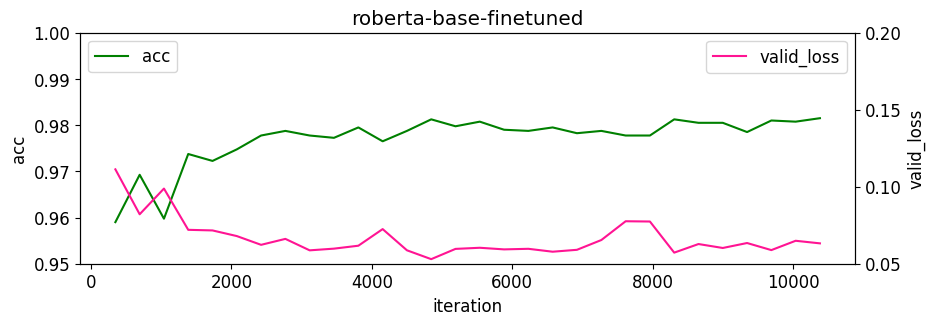

In [40]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['font.size'] = 12

x = iter_x
y1 = acc_y
y2 = loss_y

fig, ax1 = plt.subplots()
ax1.set_xlabel('iteration')
ax1.set_ylabel('acc')
ax1.plot(x, y1, color='green',label='acc')
ax1.legend(loc='upper left')
ax1.set_ylim([0.950,1])

ax2 = ax1.twinx()
ax2.set_ylabel('valid_loss')
ax2.plot(x, y2, color='deeppink',label='valid_loss')
ax2.legend(loc='upper right')
ax2.set_ylim([0.05,0.2])

plt.title("roberta-base-finetuned")

plt.show()

In [41]:
print(endtime - starttime)

1332.4832289218903
